<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/FleaBusyBeeBergs/blob/main/dtsa5506_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex -q
!pip install statsmodels==0.14.0 -q
!pip install tslearn -q
!pip install scikeras -q

In [94]:
# file handling & general
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# eda
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats

# pca
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import DBSCAN

# preprocessing & ml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, silhouette_score

from xgboost import XGBRegressor

#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

# clustering
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Introduction

The main idea of this project is to predict interest rate changes before they are announced. Interest rates affect nearly everyone and changes to the prevailing rates affect many decisions not just in the long term, but in the short term as well.

The bank of canada exercises counter-inflationary monetary policy by increasing interest to slow inflation, and decreasing interest to allow inflation to increase (and avoid recession). To predict changes to the policy interest rate, it would be helpful to first model and predict inflation. The consumer price index is a common measure of inflation, and cpi time series is available from statistics canada.

 Thinking back to when I studied economics as an undergrad, I remember the 2 drivers of inflation being cost-push and demand-pull. In this project I will focus on the cost-push side of things. Intuitively, I think of the inputs to producing goods and services as being materials and wages. For a simple model, the 2 indicators I will use from statistics canada to model cpi are the raw materials price index and average weekly wages.

 Once I have a forcast of cpi, I will use that to make predictions on whether the bank of canada will decrease, hold steady, or increase interest rates.

## Extract, Transform, Load (ETL) pipeline

Statistics Canada has a data cube available to the public, and provides instructions to make http requests [1]. I used these these instructions to request very specific information for specific dates, rather than having to download entire tables. I was able to write code for a single vector request, then spent a lot of time trying to write my own functions before turning to a code generator [2] for the following StatCanETL class.

In [3]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}


In [4]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''initialize with df of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''transform the XML response into a structured DataFrame.'''
        # parse XML content
        root = ET.fromstring(xml_content)

        # locate the series element
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        # extract obs
        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # convert date format if quarterly or yearly
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        # convert to df
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''convert quarterly date string (YYYY-Qx) to a standard date format (YYYY-MM)'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''load df into object named name_df.'''
        variable_name = f'{name}_df'
        globals()[variable_name] = df
        self.data_objects[variable_name] = df
        print(f'Data for {name} saved to object {variable_name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')

In [5]:
# metadata - define what information to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi', 'rate'],
    'tableid': [14100223, 18100268, 18100004, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seasonally adjusted, 2002 = 100', 'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973', 'v39078'],
    'vectdesc': ['', '', '', ''],
    'description': ['', '', '', ''],
    'frequency': ['monthly', 'monthly', 'monthly', 'daily'],
    'start': ['2001-01', '2001-01', '2001-01', '2001-01-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [58]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage_df
Processing rmpi...
Data for rmpi saved to object rmpi_df
Processing cpi...
Data for cpi saved to object cpi_df
Processing rate...
Data for rate saved to object rate_df


## EDA and cleaning

In [59]:
# check to see if data loaded correctly
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3), '\n')

wage_df
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14 

rmpi_df
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5 

cpi_df
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1 

rate_df
         Date  Value
0  2001-01-01    6.0
1  2001-01-02    6.0
2  2001-01-03    6.0 



In [60]:
# rename columns
wage_df.rename(columns = {'Value': 'wage',
                          'Date': 'date'},
               inplace = True)
rmpi_df.rename(columns = {'Value': 'rmpi',
                          'Date': 'date'},
               inplace = True)
cpi_df.rename(columns={'Value': 'cpi',
                       'Date': 'date'},
               inplace = True)
rate_df.rename(columns={'Value': 'rate',
                        'Date': 'date'},
               inplace = True)

In [74]:
# merge tables with monthly data
data = wage_df.merge(rmpi_df, on = 'date', how = 'outer') \
              .merge(cpi_df, on = 'date', how = 'outer')

In [62]:
print(data)
print(data.info())

        date     wage   rmpi    cpi
0    2001-01   657.14   65.2   96.3
1    2001-02   653.59   65.8   96.8
2    2001-03   655.14   65.5   97.1
3    2001-04   652.44   65.2   97.8
4    2001-05   652.28   65.3   98.6
..       ...      ...    ...    ...
283  2024-08  1274.25  139.3  161.8
284  2024-09  1277.70  134.8  161.1
285  2024-10  1284.24  140.3  161.8
286  2024-11  1285.91  140.2  161.8
287  2024-12      NaN  142.0  161.2

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   wage    287 non-null    float64
 2   rmpi    288 non-null    float64
 3   cpi     288 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB
None


At the time of writing, wage was missing one observation from 2024-12.
I assume this is because it may take a while for the data to be processed each month. I'll use forward fill to deal with that missing value. If quarterly data was pulled from the data cube, there would be missing data for the months 02-03, 05-06, 08-09, and 11-12. Forward fill could also deal with those missing observations.

In [75]:
# fill na
data = data.ffill()

In [76]:
# format date
data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m')

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   wage    288 non-null    float64
 2   rmpi    288 non-null    float64
 3   cpi     288 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB


In [66]:
# descriptive stats
data.describe()

,wage,rmpi,cpi
count,288.000000,288.000000,288.000000
mean,911.631250,99.128125,123.738542
std,170.097978,24.307042,17.143681
min,652.280000,55.300000,96.300000
25%,772.157500,84.075000,109.775000
50%,903.520000,97.050000,122.200000
75%,1009.597500,112.725000,134.225000
max,1285.910000,166.600000,162.100000


The interest rate data is published (almost) daily, but only changes at 8 pre-determined dates per year. This will require some extra wrangling to align with the other monthly series. Where the rate changes on or before the 15th of the month, I'll apply changed rate to that month. Where the rate changes after the 15th of the month, I'll apply the changed rate to the following month.

In [67]:
print(rate_df.info())
print(rate_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8766 non-null   object 
 1   rate    6231 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.1+ KB
None
              rate
count  6231.000000
mean      2.237963
std       1.519686
min       0.500000
25%       1.000000
50%       1.750000
75%       3.250000
max       6.000000


In [68]:
# date format
rate_df['date'] = pd.to_datetime(rate_df['date'])

# continuous dates
rate_df = rate_df.set_index('date')\
                           .asfreq('D')\
                           .reset_index()

# fill na
rate_df['rate'] = rate_df['rate'].ffill()

In [69]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8766 non-null   datetime64[ns]
 1   rate    8766 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB


In [70]:
# sort
rate_df = rate_df.sort_values('date')

# id rate changes
rate_df['prev_rate'] = rate_df['rate'].shift(1)
rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']

# keep only rate changes
rate_changes = rate_df.copy()

# extract year, month, and day
rate_df['year'] = rate_df['date'].dt.year
rate_df['month'] = rate_df['date'].dt.month
rate_df['day'] = rate_df['date'].dt.day

# apply 15th of month rule
rate_df['effective_month'] = rate_df.apply(
    lambda row: row['month'] if row['day'] <= 15 else (row['month'] % 12 + 1),
    axis=1)

rate_df['effective_year'] = rate_df.apply(
    lambda row: row['year'] if row['day'] <= 15 else (row['year'] + (row['month'] == 12)),
    axis=1)

# drop old year and month column
rate_df.drop(columns = ['year', 'month'],
                  inplace = True)

# drop duplicates
rate_df = rate_df.sort_values('date')\
                           .drop_duplicates(subset = ['effective_year',
                                                      'effective_month'], keep = "last")

# rename colunms create date col
rate_df = rate_df.rename(columns = {'effective_year': 'year',
                                              'effective_month': 'month'})
rate_df['day'] = 1

# convert datetime
rate_df['date'] = pd.to_datetime(rate_df[['year', 'month', 'day']])

# drop cols
rate_df = rate_df.drop(columns = ['prev_rate', 'rate_changed', 'year', 'month', 'day'])

# format date
rate_df['date'] = pd.to_datetime(rate_df['date']).dt.strftime('%Y-%m')

In [77]:
rate_df.head()

,date,rate
14,2001-01,6.00
45,2001-02,5.75
73,2001-03,5.25
104,2001-04,5.25
134,2001-05,5.00


In [78]:
data = data.merge(rate_df, on = 'date', how = 'outer').set_index('date')

In [79]:
data.head()

,wage,rmpi,cpi,rate
date,,,,
2001-01,657.14,65.2,96.3,6.00
2001-02,653.59,65.8,96.8,5.75
2001-03,655.14,65.5,97.1,5.25
2001-04,652.44,65.2,97.8,5.25
2001-05,652.28,65.3,98.6,5.00


In [82]:
scaler = StandardScaler
data_scaled = data.copy()
data_scaled[['wage', 'rmpi', 'cpi', 'rate']] = scaler().fit_transform(data[['wage', 'rmpi', 'cpi', 'rate']])
data_scaled.describe()

,wage,rmpi,cpi,rate
count,2.880000e+02,2.880000e+02,2.880000e+02,2.890000e+02
mean,4.934325e-16,-4.934325e-16,2.467162e-16,-1.229313e-16
std,1.001741e+00,1.001741e+00,1.001741e+00,1.001735e+00
min,-1.527371e+00,-1.806243e+00,-1.603291e+00,-1.152127e+00
25%,-8.213885e-01,-6.203687e-01,-8.159186e-01,-8.247281e-01
50%,-4.776876e-02,-8.564359e-02,-8.990016e-02,-3.336297e-01
75%,5.769426e-01,5.603538e-01,6.127454e-01,6.485671e-01
max,2.204202e+00,2.780648e+00,2.241539e+00,2.449261e+00


Let's have a look at what the plotted data looks like.

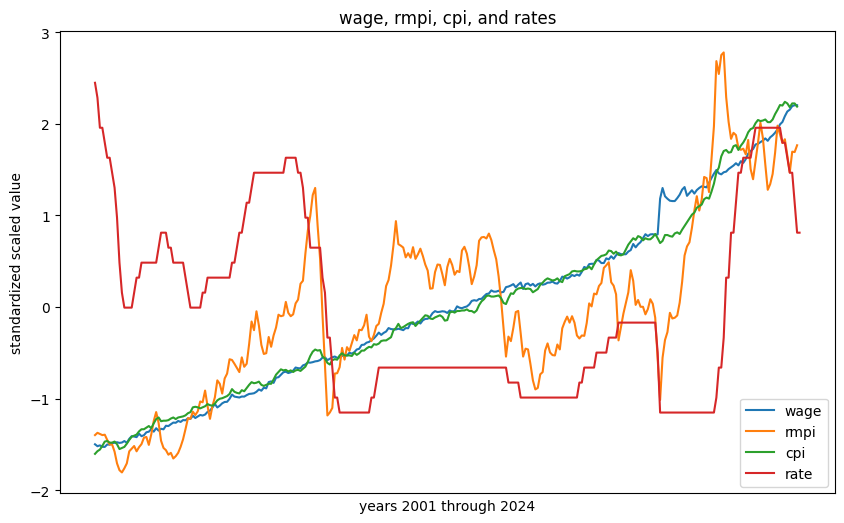

In [90]:
plt.figure(figsize=(10, 6))

for col in data_scaled.columns:
   plt.plot(data_scaled.index,
            data_scaled[col],
            linestyle = '-',
            label = col)

plt.xlabel('years 2001 through 2024')
plt.xticks([])
plt.ylabel('standardized scaled value')
plt.title('wage, rmpi, cpi, and rates')
plt.legend()
plt.show()

In the figure above, we can see that wage appears to be closely correlated with the cpi with a nearly-constant upward linear trend. rmpi is relatively more volatile but appears to also follow an upward trend.

## Differencing

HP differencing breaks down a time series into trend and seasonal components.

In [108]:
data_diff = data.copy()

In [114]:
data_diff = data_diff.iloc[:-1]

In [115]:
data_diff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 2001-01 to 2024-12
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wage      288 non-null    float64
 1   rmpi      288 non-null    float64
 2   cpi       288 non-null    float64
 3   rate      288 non-null    float64
 4   cpi_diff  0 non-null      float64
dtypes: float64(5)
memory usage: 13.5+ KB


In [139]:
# hp filter
lambda_value = 50
cycle, trend = sm.tsa.filters.hpfilter(data_diff['cpi_diff'], lamb=lambda_value)

# Store in DataFrame
data_diff['cpi_trend'] = trend
data_diff['cpi_cycle'] = cycle

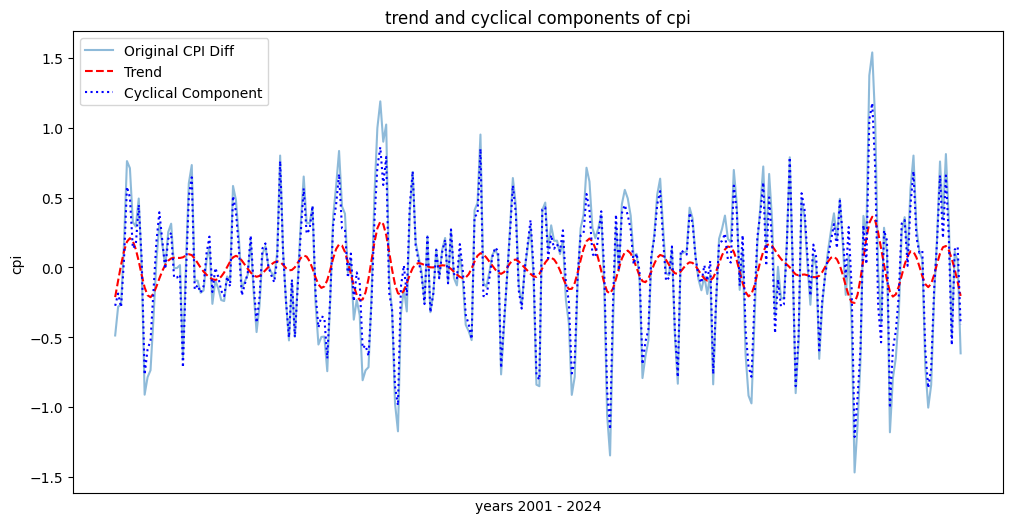

In [140]:
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(data_diff.index, data_diff['cpi_diff'], label='Original CPI Diff', alpha=0.5)

# Plot Trend
plt.plot(data_diff.index, data_diff['cpi_trend'], label='Trend', linestyle='dashed', color='red')

# Plot Cyclical Component
plt.plot(data_diff.index, data_diff['cpi_cycle'], label='Cyclical Component', linestyle='dotted', color='blue')

plt.xlabel('years 2001 - 2024')
plt.xticks([])
plt.ylabel('cpi')
plt.title('trend and cyclical components of cpi')
plt.legend()
plt.show()


In [ ]:
# prompt: plot trend component of cpi

# Assuming 'data_diff' DataFrame from the provided code is available.

plt.figure(figsize=(10, 6))
plt.plot(data_diff.index, data_diff['cpi_diff'], label='CPI Cyclical Component')
plt.xlabel('Date')
plt.ylabel('CPI Cyclical Component')
plt.title('Cyclical Component of CPI')
plt.legend()
plt.show()


In [ ]:
warnings.filterwarnings("ignore")

# Apply HP differencing
lambda_value = 50
_, trend = hpfilter(hp_data["cpi"], lamb=lambda_value)
hp_data["cpi_hp_diff"] = hp_data["cpi"] - trend  # HP differenced CPI

# Define search range for (p, d, q)
p_values = range(0, 7)  # Auto-regressive terms
d_values = [0]       # Differencing terms (HP may already remove trend)
q_values = range(0, 5)  # Moving average terms

# Generate all possible (p, d, q) combinations
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

# Grid search for best (p, d, q)
best_aic = float("inf")
best_pdq = None
best_model = None

for pdq in pdq_combinations:
    try:
        model = sm.tsa.ARIMA(hp_data["cpi_hp_diff"], order=pdq)
        model_fit = model.fit()

        aic = model_fit.aic
        print(f"ARIMA{pdq} - AIC: {aic}")

        if aic < best_aic:
            best_aic = aic
            best_pdq = pdq
            best_model = model_fit
    except:
        continue  # Skip failed models

# Print best parameters
print(f"\nBest ARIMA Order: {best_pdq} with AIC: {best_aic}")

### ARIMA model

The auto-regressive integrate moving average model is not a machine learning model, but a statistical model that is frequently used on time series data. It models series based upon its own prior values.

## References

*   List item
*   List item

